# Goal：Increase Conversion Rate
Conversion Rate = # Conversions/ # Total Sessions

In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
# read in data
data = pd.read_csv('/Users/mengli/Desktop/OPT/项目/Data Challenge/Conversion rate/conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## Exploratory Analysis
### Check Data Quality

In [3]:
print(data.describe())

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000


In [4]:
print(data.groupby(['country']).size())

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64


In [5]:
print(data.groupby(['source']).size())

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64


A few quick observations:
- The site is probably a US site, although it has a large customer base from China
- Conversion rate at around 3% is industry standard, it makes sense
- The customer base is pretty yong, with a median of 30
- Max age 123 is beyond life expectancy in US (around 80), there should be something wrong

In [6]:
print(sorted(data['age'].unique(), reverse = True))

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


In [7]:
print(data[data['age'] >110])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


Ages of 123 and 111 are unrealistic, since there are only 2 records of them, I would just remove those rows

In [8]:
#remove age outliers
data = data[data['age'] <= 110]

### Check Correlation between DV and IVs

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


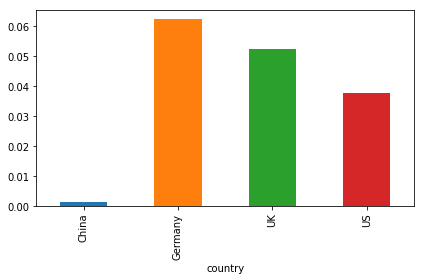

In [10]:
data.groupby(['country'])['converted'].mean().plot.bar()
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


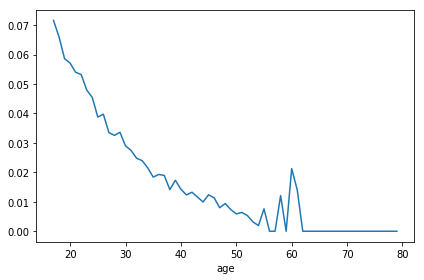

In [11]:
data.groupby(['age'])['converted'].mean().plot()
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


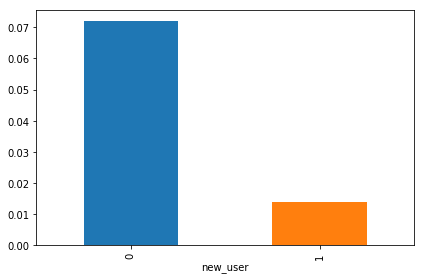

In [12]:
data.groupby(['new_user'])['converted'].mean().plot.bar()
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


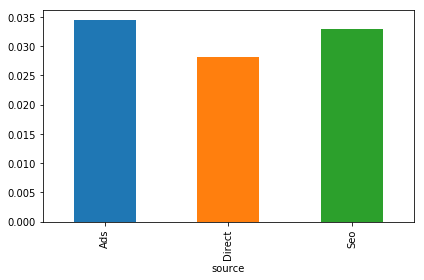

In [13]:
data.groupby(['source'])['converted'].mean().plot.bar()
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


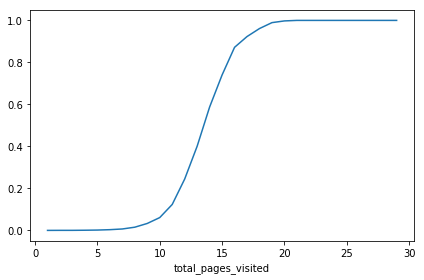

In [14]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.show()

Findings:
- Users from China have extreme low probability to convert
- Repeated user are more likely to convert
- Different sources have slightly influence of users' conversion
- Users with higher total pages visited are more likely to convert

## Model Building
### Version 1

In [15]:
data_dummy = pd.get_dummies(data, drop_first=True)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [17]:
np.random.seed(4684)
train, test = train_test_split(data_dummy, test_size=0.25)
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round()))
)


OOB accuracy is 0.9843093764231619 
 OOB Confusion Matrix 
         0     1
0  228290  1221
1    2500  5137


In [18]:
#print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1))))
)

Test accuracy is 0.9851486401012017 
 Test Set Confusion Matrix 
        0     1
0  76097   392
1    782  1779


In [19]:
tn, fp, fn, tp = confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1))).ravel()

In [20]:
print(tn, fp, fn, tp)

76097 392 782 1779


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


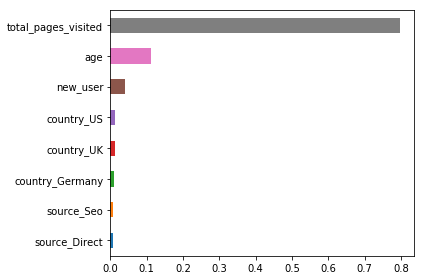

In [21]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

In [22]:
feat_importances = pd.DataFrame(rf.feature_importances_, 
                             index=train.drop('converted', axis=1).columns,
                             columns=['importance']).sort_values('importance', ascending=False)
                             

In [23]:
feat_importances

,importance
total_pages_visited,0.796290
age,0.111194
new_user,0.040678
country_US,0.013987
country_UK,0.012137
country_Germany,0.010673
source_Seo,0.008175
source_Direct,0.006865


Total pages visited can be the result of converted since people need to click multiple pages to finish shopping. Thus, it's better to remove it in model building. 

### Version 2
Let’s rebuild the RF without the total_page_visited variable. Since classes are heavily unbalanced and we don’t have that very powerful variable anymore, let’s change the weights, just to make sure we will get something classified as 1.

In [25]:
#build the model without total_pages_visited
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

#print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.8920884848280399 
 OOB Confusion Matrix 
         0      1
0  208174  21337
1    4254   3383


In [27]:
#print test accuracy and confusion matrix
print(
'Test accuracy is', rf.score(test.drop(['converted', 'total_pages_visited'], axis=1), test['converted']),
'\n',
'Test Set Confusion Matrix',
'\n',
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted','total_pages_visited'], axis=1)), labels=[0, 1])))


Test accuracy is 0.8909677419354839 
 Test Set Confusion Matrix 
        0     1
0  69321  7168
1   1451  1110


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


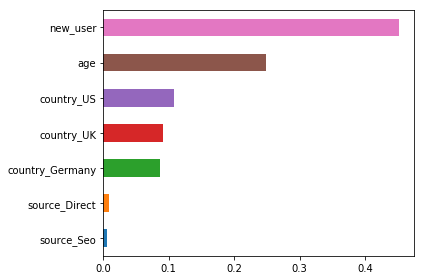

In [32]:
#check feature importance
feat_importances = pd.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

In [28]:
#check feature importance
feat_importances = pd.DataFrame(rf.feature_importances_, 
                             index=train.drop(['converted', 'total_pages_visited'], axis=1).columns,
                             columns=['importance']).sort_values('importance', ascending=False)
feat_importances

,importance
new_user,0.452193
age,0.248100
country_US,0.107627
country_UK,0.091255
country_Germany,0.086159
source_Direct,0.008436
source_Seo,0.006231


Findings:
- New user or not is the most important feature, even higher than continuous variable age, which means that it's of high importance
- User source seems have little influnce in whether user will converted at last

#### Check partial dependence

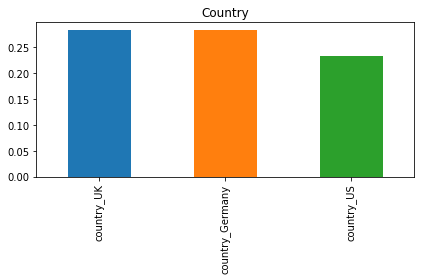

In [43]:
#country
from pdpbox import pdp, info_plots
pdp_iso = pdp.pdp_isolate(model=rf,
                         dataset=train.drop(['converted','total_pages_visited'], axis=1),
                         model_features=list(train.drop(['converted','total_pages_visited'], axis=1)),
                         feature=['country_Germany', 'country_UK', 'country_US'],
                         num_grid_points=50)

pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

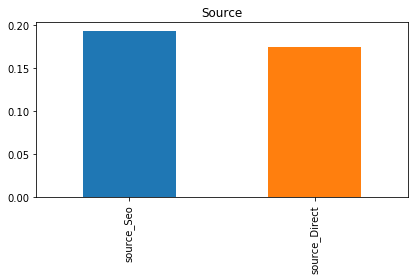

In [45]:
#source
pdp_iso = pdp.pdp_isolate(model=rf,
                         dataset=train.drop(['converted','total_pages_visited'], axis=1),
                         model_features=list(train.drop(['converted','total_pages_visited'], axis=1)),
                         feature=['source_Direct', 'source_Seo'],
                         num_grid_points=50)

pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

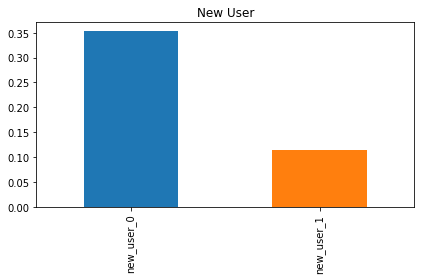

In [47]:
#new user
pdp_iso = pdp.pdp_isolate(model=rf,
                         dataset=train.drop(['converted','total_pages_visited'], axis=1),
                         model_features=list(train.drop(['converted','total_pages_visited'], axis=1)),
                         feature='new_user',
                         num_grid_points=50)

pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()

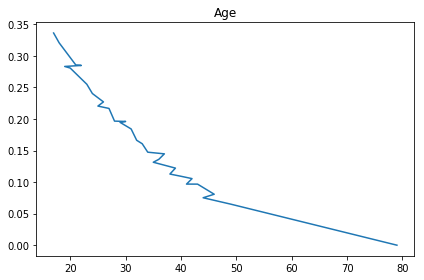

In [53]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.sort_values(ascending=False).plot(title='Age')
plt.show()

Findings
- Users with old accounts are much more likely to convert
- UK, US, Germany all have relative significant importance on users' conversion in comparison with China
- This site works very well for yong people and gets worse for older people
- Diffrent sources have similar influnce on users' conversion

In [57]:
#build a simple decision tree and check the 2 or 3 most important segments:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
tree = DecisionTreeClassifier(max_depth=2, class_weight={1:0, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

#visualize it
export_graphviz(tree, out_file='tree_conversion.dot', 
                feature_names=train.drop(['converted','total_pages_visited'], axis=1).columns,
               proportion=True, 
                rotate=True)
with open('tree_conversion.dot') as f:
    dot_graph =f.read()

s = Source.from_file('tree_conversion.dot')
s.view()



'tree_conversion.dot.pdf'

### Conclusions and next steps
- The site is working very well for young users. Definitely let’s tell marketing to advertise and use channels which are more likely to reach young people.
- The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.
- Users with an old account are more likely to convert. Bring old user back to the site via email such as offers information, new product or back in stock alert could probably increase # converted users.

- Maybe go through the UI and figure out why older users perform so poorly? From ~30 y/o conversion clearly starts dropping. A good actionable metric here is conversion rate for people >=30 yr old. Building a team whose goal is to increase that number would be interesting.
- Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, or maybe some payment issue. Given how many users are based in China, fixing this should be a top priority. Huge opportunity. 

